# Gradient Boosting Trees
## Final de Aprendizaje Supervisado
## 2021 S2

Profesores: Pablo Vena, Martín Savransky


# Tabla de Contenidos

1. Teoría Básica
  1. Boosting como expansión de bases (ESL 10.2-10.3)
  2. Gradient Boosting como caso particular de Steepest Descent (ESL 10.10)
  3. Hiperparámetros: $M$, $J$ y $\nu$; "shrinkage" (ESL 10.11-10.12)

2. ¡Código!
  1. MeanRegressor: una clase simple en Python
  2. GBRegressor: nuestro booster de juguete (ESL Algoritmo 10.3)
  3. Comparación con algoritmos "testigo"
  4. Exploración básica de hiperparámetros

3. GB a escala industrial
  1. ¿Por qué Gradient Boosting? (ESL 10.7)
  2. Caso de estudio: CTR y otros estimadores @ Jampp

## 1. Teoría Básica

Freund y Schapire (1997) describen un algoritmo de clasificación en 2 clases $\{-1, +1\}$, "AdaBoost.M1.", con la premisa de combinar varios _clasificadores débiles_ $G_m(x),\ m=1,2\dots, M$ en un _clasificador fuerte_ final $G(X) = f\left(\sum_{i=1}^{M} \alpha_m G_m(x)\right)$.
- Sorprendentemente efectivo en varios contextos
- Se puede extender a clasificación multiclase y regresión
- Ha encontrado sólidos cimientos teóricos en los años posteriores

### 1.1. Boosting como expansión de bases

PCA (análisis de componentes principales), FDA (análisis de datos funcionales) y otras tantas técnicas, explotan la idea de _expansión en bases_ (funcionales o vectoriales), para expresar una función $f(x)$ arbitrariamente compleja como suma sobre una _base_ de funciones elementales:

$$ f(x) = \sum_{m=1}^{M} \beta_m b(x;\gamma_m)$$

- $\beta_m, m=1,\dots,M$ son los coeficientes de la expansión y
- $b(x; \gamma)$ son las funciones base definidas por un conjunto de parámetros $\gamma$.

- En PCA, las "funciones" son los vectores $\gamma \in \mathbb{R}^n$ sobre los que se toma la proyección de $x$.

- En FDA, $\gamma$ caracteriza los _splines_ (sus nudos, el grado y los coeficientes de cada polinomio) utilizados.

- En NNs de una única capa oculta, las activaciones de la capa oculta $b(x;\gamma)=\sigma(\gamma_0 + \gamma_1^{T}x)$ (donde $\sigma$ es la función de activación) forman una base _no lineal_ sobre combinaciones _lineales_ $\gamma_0 + \gamma_1^{T}x$ de los $x$ predictores originales.

En Boosting, las funciones de bases  son regresores/clasificadores sencillos (típicamente árboles de poquísimas hojas). Si usamos _stumps_ ("tocones" de 2 hojas), $\gamma \in p \times \mathbb{R}^3$ parametriza

1. el índice $i$ de un predictor,
2. un punto de corte $s$ sobre $i$, y
3. las predicciones $p_0$ y
4. $p_1$ a ambos lados del corte.

Estos modelos se ajustan minimizando una función de pérdida $L$ (error cuadrático, corss-entropy, etc.) promediada sobre los datos de entrenamiento.

$$
\min _{\left\{\beta_{m}, \gamma_{m}\right\}_{1}^{M}} \sum_{i=1}^{N} L\left(y_{i}, \sum_{m=1}^{M} \beta_{m} b\left(x_{i} ; \gamma_{m}\right)\right)
$$

Encontrar los $\left\{\beta_{m}, \gamma_{m}\right\}_{1}^{M}$ óptimos es un problema formidable, que se puede aproximar razonablemente si existe una forma adecuada de ajustar una única función base por vez.

### Forward Stagewise Additive Modelling

El "modelado aditivo hacia delante por etapas", aproxima la solución del problema general, añadiendo secuencialmente nuevas bases, _sin alterar los parámetros de las anteriores_.

![Algoritmo 10.2](../FSAM_small.png)

Nótese que para la pérdida cuadrática y una observación $(x_i, y_i)$ cualquiera, la pérdida en 2(a) es equivalente a 

$$
\begin{aligned}
L\left(y_{i}, f_{m-1}\left(x_{i}\right)+\beta b\left(x_{i} ; \gamma\right)\right) &=\left(y_{i}-f_{m-1}\left(x_{i}\right)-\beta b\left(x_{i} ; \gamma\right)\right)^{2} \\
&=\left(r_{i m}-\beta b\left(x_{i} ; \gamma\right)\right)^{2}
\end{aligned}
$$

Con lo cual la m-ésima función de base ¡será aquella que mejor ajuste los residuos del último predictor $f_{m-1}$! Esta es la idea clave para usar Boosting en regresión.

### 1.2. Gradient Boosting como caso particular de Steepest Descent (ESL 10.10)

Dada una función de pérdida diferenciable $L$, el "aprendizaje" de una función $f(x)$ que prediga $y$ implica encontrar $f$ que minimiza

$$
L(f)=\sum_{i=1}^{N} L\left(y_{i}, f\left(x_{i}\right)\right)
$$

Que se peude ver como un problema de optimización numérica, 

$$
\hat{\mathbf{f}}=\arg \min _{\mathbf{f}} L(\mathbf{f})
$$

donde los "parámetros"

$$\mathbf{f}=\left\{f\left(x_{1}\right), f\left(x_{2}\right)), \ldots, f\left(x_{N}\right)\right\}$$

son las predicciones en cada una de las $N$ observaciones de entrenamiento.

Los métodos de optimización numérica resuelven estos problemas a través de una suma de vectores

$$
\mathbf{f}_{M}=\sum_{m=0}^{M} \mathbf{h}_{m}, \quad \mathbf{h}_{m} \in \mathbb{R}^{N}
$$

, comenzando desde una conjetura inicial $\mathbf{f}_0 = \mathbf{h}_0$, y cada $\mathbf{f}_m$ sucesiva es inducida a partir del vector actual $\mathbf{f}_{m-1}$. Distintos métodos difieren en sus prescripciones sobre cómo calcular cada paso ("step") $\mathbf{h}_m$.

### Steepest Descent

_Steepest descent_ toma $\mathbf{h}_{m} = -\rho_m\mathbf{g}_{m}$, donde $\rho_m$ es un escalar y $\mathbf{g}_{m} \in \mathbb{R}^N$ es el gradiente de $L(\mathbf{f})$ evaluado en $\mathbf{f}=\mathbf{f}_{m-1}$. Los componentes $g_{im}$ son

$$
g_{i m}=\left[\frac{\partial L\left(y_{i}, f\left(x_{i}\right)\right)}{\partial f\left(x_{i}\right)}\right]_{f\left(x_{i}\right)=f_{m-1}\left(x_{i}\right)}
$$

y el _largo del paso_ $\rho_m$ es la solución de

$$
\rho_{m}=\arg \min _{\rho} L\left(\mathbf{f}_{m-1}-\rho \mathbf{g}_{m}\right)
$$

Finalmente, la solución actual se actualiza según $\mathbf{f}_{m}=\mathbf{f}_{m-1}-\rho_{m} \mathbf{g}_{m}$. Esta es una estrategia _muy_ codiciosa ("greedy"), ya que $-\mathbf{g}_{m}$ es la dirección _local_ para la cual $L(\mathbf{f})$ desciende más rapidamente en $\mathbf{f} = \mathbf{f}_{m-1}$ .

### Gradient Boosting

Un árbol de decisión $T$ con $J$ regiones, se puede expresar formalmente como 

$$
T(x ; \Theta)=\sum_{j=1}^{J} \gamma_{j} I\left(x \in R_{j}\right)
$$

con parámetros $\Theta = \{R_j,\gamma_j\}_{j=1}^J$, donde la cantidad de regiones terminales $J$ es un hiperparámetro.

Si usamos árboles para construir un predictor con _forward stagewise boosting_, en cada paso el nuevo árbol es aquél que más reduce la pérdida, y por ende sus predicciones son análogas a los componentes del gradiente negativo $-\mathbf{g}_{m}$. La diferencia, es que las predicciones $\mathbf{t}_{m} = \left( T(x_1 ; \Theta_m), \dots, T(x_N ; \Theta_m)\right)$ están limitadas a ser las predicciones de un árbol con $J_m$ nodos terminales, mientras que el gradiente negativo es la dirección de máximo descenso irrestricto.

Si el objetivo fuese simplimente minimizar la pérdida en la data de entrenamiento, _steepest descent_ sería la estrategia preferida: el gradiente es trivial de calcular para cualquier pérdida $L$ diferenciable, mientras que encontrar el árbol óptimo para $L$ no-triviales es un un incordio. Lamentablemente, **el gradiente sólo está definido sobre las observaciones de entrenamiento**, y nuestro objetivo es generalizar los resultados a casos aún no vistos.

Una solución posible, es ajustar a cada paso un árbol $T(x ; \Theta_m)$ cuyas predicciones sean lo más cercanas posibles al gradiente negativo.

Si medimos cercanía por el error cuadrado, tenemos que 

$$
\tilde{\Theta}_{m}=\arg \min _{\Theta} \sum_{i=1}^{N}\left(-g_{i m}-T\left(x_{i} ; \Theta\right)\right)^{2}
$$

Si además tomamos una pérdida cuadrática, el gradiente $-g_im = y_i - f_{m-1}(x_i)$, y en cada iteración, el nuevo árbol es aquél que mejor se ajusta a los residuos del modelo actual. ¡Intuitivo!

### 1.3. Hiperparámetros: $M$, $J$ y $\nu$; "shrinkage" (ESL 10.11-10.12)

### J: la cantidad de nodos como control del orden de interacciones

Una decisión común, para evitar que los primeros árboles "dominen" el modelo, es forzar idénticos $J_1 = \dots = J_m = J$, y luego setear $J$ a un valor bastante bajo, que resulta ser un hiperparámetro del modelo a ajustar por validación cruzada o similares métodos.

Como un árbol de $J$ hojas no puede representar combinaciones de más de $J-1$ variables, una interpretación útil de $J$, es como control sobre el máximo orden de las interacciones representadas en el modelo. 

En general, las interacciones de bajo orden dominan las aplicaciones "de la vida real", y $J \approx 6$ suele alcanzar.

### M: la cantidad de árboles

En general, cada árbol sucesivo hará bajar _algo_ el riesgo $L(f_M)$ de entrenamiento, con lo cual para $M$ suficientemente grande, el modelo de seguro sobreajustará.

El óptimo $M^{*}$ que minimiza el riesgo en observaciones aún no vistas se puede aproximar separando un conjunto de validación, y deteniendo el procedimiento ("early stopping") cuando el riesgo en el conjunto de validación ya no disminuye.

### $\nu$: encogimiento, o la importancia de aprender despacio

Como _ridge_ en modelos lineales y _dropout_ en redes neuronales, técnicas de encogimiento ("shrinkage") son sumamente - de hecho, _particularmente_ - útiles en boosting. La manera más sencilla, es multiplicar los aportes de cada árbol por un factor $0 < \nu < 1$, de manera que $f_m(x) = f_{m-1}(x) + \nu \cdot T(x ; \Theta_m)$.

$\nu$ se puede pensar como la _tasa de aprendizaje_ durante el proceso de boosting, crítica a cualquier método de descenso de gradiente.

Obviamente, $\nu$ y $M$ tienen efectos correlacionados, con lo cual han de elegirse conjuntamente. En general, dado que entrenar un modelo para $M_1 > M_0$ _implica_ entrenar un modelo de $M_0$ bases, una práctica sencilla es elegir un $\nu$ muy pequeño ($0.01$ o aún menor), un valor máximo $\bar{M}$ tal que $\nu \times \bar{M} \approx 5$, y luego elegir $M^*$ por _early stopping_. El costo incurrido es computacional, pero eligiendo $J$ lo suficientemente pequeño, el resultado neto es más que manejable.

## 2. Código

### Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

plt.style.use("ggplot")

In [2]:
df = pd.read_csv("../data/hitters.csv").dropna()
df.shape

(263, 20)

In [3]:
X = df.drop(columns="Salary")
y = df.Salary

categorical_features = X.columns[X.dtypes == "O"].tolist()
X_cat, X_num = X[categorical_features], X.drop(columns=categorical_features)
ohe = OneHotEncoder(drop="first", sparse=False).fit(X_cat)

X = pd.concat(
    [
        pd.DataFrame(
            data=ohe.transform(X_cat).astype(int),
            columns=ohe.get_feature_names_out(categorical_features)
        ),
        X_num.reset_index(),
    ],
    axis=1,
)

In [4]:
X.head()

,League_N,Division_W,NewLeague_N,index,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
0,1,1,1,1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10
1,0,1,0,2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14
2,1,0,1,3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3
3,1,0,1,4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4
4,0,1,0,5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25


### 2.1. MeanRegressor: una clase simple en Python

In [5]:
class MeanRegressor:
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        self.y_mean = y.mean()
        return self
        
    def predict(self, X):
        return self.y_mean * np.ones(X.shape[0])

### 2.2. GBRegressor: nuestro booster de juguete (ESL Algoritmo 10.3)

In [6]:
class GBRegressor:
    
    def __init__(self, J, M, nu):
        self.J = J
        self.M = M
        self.nu = nu
        
    def fit(self, X, y):
        # En `preds`, cada fila representa árbol, cada columna una observación,
        # cada celda la prediccion del gradiente/seudoresiduo
        self.preds = np.zeros((self.M, X.shape[0]))
        self.trees = []
        self.y_mean = y.mean()
        for m in range(self.M):
            resid = y - self.y_mean - np.sum(self.preds[:m], axis=0)
            t = DecisionTreeRegressor(max_leaf_nodes=self.J).fit(X, resid)
            self.trees.append(t)
            self.preds[m] = self.nu * t.predict(X)
        return self

    def predict(self, X):
        return self.y_mean + self.nu * sum(t.predict(X) for t in self.trees)

### 2.3. Comparación con algoritmos "testigo"

In [7]:
seed = 1991
test_size = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [8]:
# Algo 10.3 Gradient Tree Boosting Algorithm (p.361 ESL, p.380 pdf)
# Hiperparámetros
M = 500  # Numero de árboles
J = 3  # Número de hojas de cada árbol
nu = 0.01  # Shrinking factor / tasa de aprendizaje

In [9]:
gbr = GBRegressor(J, M, nu).fit(X_train, y_train)

In [10]:
bigtree = DecisionTreeRegressor().fit(X_train, y_train)

In [11]:
def preds_path(gbr, X):
    preds = np.ones(shape=(gbr.M + 1, X.shape[0])) * gbr.y_mean
    partial_preds = gbr.nu * np.row_stack(list(t.predict(X) for t in gbr.trees))
    preds[1:, :] += np.cumsum(partial_preds, axis=0)
    return preds
        
train_preds = preds_path(gbr, X_train)
test_preds = preds_path(gbr, X_test)

In [12]:
gb_mses = []
for i in range(M + 1):
    gb_mses.append(
        {
            "iteration": i,
            "test": mse(y_test, test_preds[i]),
            "train": mse(y_train, train_preds[i]),
        }
    )    
gb_mses = pd.DataFrame(gb_mses).melt("iteration", var_name="set", value_name="mse")

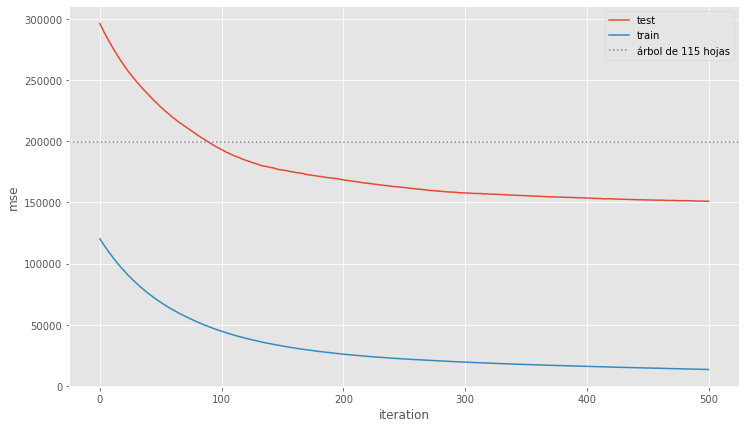

In [13]:
plt.figure(figsize=(12, 7))
sns.lineplot(x="iteration", y="mse", hue="set", data=gb_mses)
plt.axhline(
    mse(y_test, bigtree.predict(X_test)),
    color="gray",
    linestyle="dotted",
    label=f"árbol de {bigtree.get_n_leaves()} hojas"
)
plt.legend()
plt.show()

In [14]:
regressors = {
    "boosting": GBRegressor(J, M, nu),
    "linear regression": LinearRegression(),
    "random forest": RandomForestRegressor(),
    "single tree": DecisionTreeRegressor(),
    "mean": MeanRegressor(),
}
all_mses = []
for name, regr in regressors.items():
    regr = regr.fit(X_train, y_train)
    all_mses.extend([
        {"set": "train", "regressor": name, "mse": mse(y_train, regr.predict(X_train))},
        {"set": "test", "regressor": name, "mse": mse(y_test, regr.predict(X_test))},
    ])
all_mses = pd.DataFrame(all_mses)

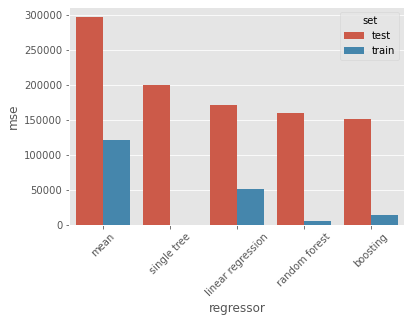

In [15]:
sns.barplot(x="regressor", y="mse", hue="set", data=all_mses.sort_values("mse", ascending=False))
plt.xticks(rotation=45)
plt.show()

In [16]:
all_mses.pivot("regressor", "set", "mse").apply(lambda x: (x / 1000).round(2)).sort_values("test")

set,test,train
regressor,,
boosting,151.00,13.33
random forest,160.06,5.32
linear regression,171.07,51.46
single tree,199.03,0.00
mean,296.34,120.24


### 2.4. Exploración básica de hiperparámetros

In [17]:
cache = False
MMax = 3000
Js = [2, 3, 4, 5]
nus = [0.001, 0.01, 0.1]
if cache:
    cv_mses = pd.read_csv("cv_mses.csv") 
else:
    for J in Js:
        for nu in nus:
            print(f"J = {J}, nu = {nu}")
            gbr = GBRegressor(J, MMax, nu).fit(X_train, y_train)
            test_preds = preds_path(gbr, X_test)
            for i in range(MMax + 1):
                cv_mses.append({"iteration": i, "J": J, "nu": nu, "mse": mse(y_test, test_preds[i])})
    cv_mses = pd.DataFrame(cv_mses)
    cv_mses.to_csv("cv_mses.csv", index=False)

In [18]:
cv_mses.to_csv("cv_mses.csv", index=False)

In [19]:
cv_mses.shape

(36012, 4)

<AxesSubplot:xlabel='iteration', ylabel='mse'>

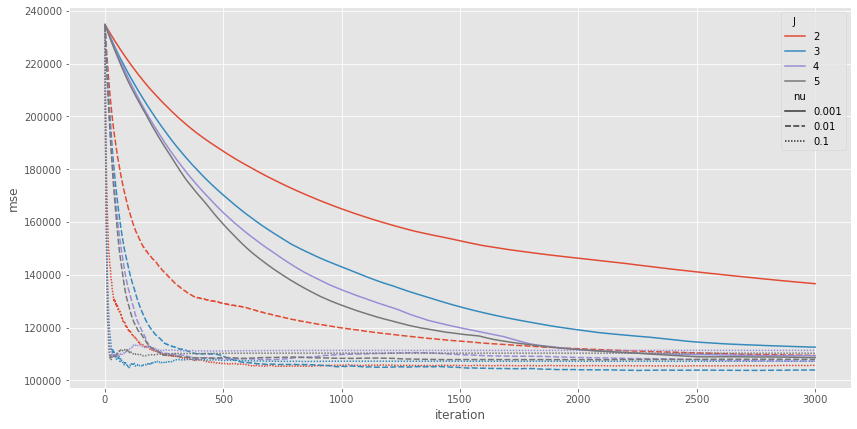

In [20]:
cv_mses[["J", "nu"]] = cv_mses[["J", "nu"]].astype(str)
plt.figure(figsize=(14, 7))
sns.lineplot(x="iteration", y="mse", hue="J", style="nu", data=cv_mses)

## 3. GB a escala industrial

### 3.1. ¿Por qué Gradient Boosting? ($\approx$ESL 10.7)

En aplicaciones industriales y comerciales, las condiciones en las que se entrenan los modelos pueden ser bastante adversas. Además de requerir precisión en las predicciones, 

- el tamaño de los datasets (en cantidad de observaciones $N$ y número de predictores $p$) es inmenso, con $N \approx 10^{10}$ y $p \approx 10^6$ o mayores,

- al requerir tantas predicciones, los costos (en cómputo y memoria) son no-triviales y la performance es crítica,

- no alcanza con modelos "caja negra" que "te dejen a pata" cuando no funcionan: _interpretar_ por qué se dio cierta predicción es clave para "debugear" y mejorar los procesos.

Distintos procedimientos tienen distintas ventajas, pero en los últimos años Gradient Boosting, en especial basándose en árboles, parece haber surgido como una excelente solución de compromiso. Aunque sus predicciones no sean siempre las óptimas, son lo suficientemente buenas ("good enough") como para ser competitivas, pero además:

- con hiperparámetros bien elegidos, el entrenamiento escala lineal o hasta sub-linealmente en $N$ y $p$,

- los árboles se pueden representar con estructuras casi triviales en memoria, y recorrerlos es aún más barato que evaluar un modelo lineal (que no es más que un producto escalar entre vectores),

- (sobre todo con $J$ pequeño) se prestan particularmente a la interpretabilidad,

- requieren un mínimo esfuerzo del científique/analista de datos para comenzar a utilizarlos.

En particular,

- no requieren definir un modelo explícito (arquitectura de red, fórmula del modelo lineal, etc.),

- lidian naturalmente con variables categóricas (y algunas implementaciones, como LightGBM, ni siquiera requieren OHE previo),

- lidian naturalmente con datos faltantes (como una categoría más).

### 3.2. Caso de estudio: CTR y otros estimadores @ Jampp

Interludio: Real-time bidding

Supongamos que el mercado está compuesto de $K$ ubicaciones donde podemos mostrar un aviso, cada una tiene un costo $c_k$ y nuestro cliente nos pagará un valor $v \geq \text{max}(c_k)$ únicamente por aquellas que resulten en avisos clickeados, demostrando intención de parte del usuario.

¿Cómo construyo una regla de decisión que maximice la ganancia?

Una idea natural, es entrenar un clasificador que clasifique cada aviso como $1$ si recibirá un click o $0$ si no. Luego, compraremos todos aquellos avisos clasificados como $1$.

La confianza del clasificador no es la misma en todas sus predicciones. ¿Por qué no comprar _ningún_ aviso por debajo y _todo_ aviso por encima de cierta cota?

Con un clasificador entrenado entrenado y calibrado, existen métodos para predecir las _probabilidades_ de clase. Pero aún así, ¿qué hacemos con las probabilidades de clases?

Sea $X_k$ una variable aleatoria, que toma el valor $1$ si el k-ésimo aviso es clickeado, y $0$ si no. Si la _probabilidad_ de que el aviso $k$ sea clickeado es $p_k$, un modelo razonable es que $X_k \sim \text{Bernoulli}(p_k)$, y $X_i, X_j$ son independientes $\forall i\neq j$. 

La decisión $d_k$ que se nos presenta ante cada subasta es elegir entre $\text{compra, no compra}$.De no comprar, la ganancia neta $G_k$ es $0$ siempre. En caso de comprar, $E(G_k|compra) = P(X_k = 1) \cdot v - c_k = p_k \cdot v - c_k$. Finalmente, compraré el espacio si y sólo si

\begin{align}
E(g_k | \text{compra}) &> E(g_k | \text{no compra}) \\
p_k \cdot v - c_k &> 0 \\
p_k &> \frac{c_k}{v}
\end{align}

De manera que un estimador de $p_k \in [0, 1]$ alcanza para formular una regla de decisión que maximice nuestra ganancia esperada, al menos. 

Una dificultad importante, en estos problemas, es el desbalance de clases, por 2 más órdenes de magnitud. En clicks $p_k \approx 0.0\approx 10^{-5}$. La recomendación tradicional es muestrear los negativos, y luego pesarlos de manera acorde. Pero con pesos rutinariamente gigantes, el comportamiento de los splits se vuelve errático. 

Una alternativa, consiste en muestrar los negativos a cierta tasa $t \approx p_k$, y entrenar un _regresor_ sin pesos. En su lugar, las predicciones que dé este estimador desbalanceado, se ajustan por la tasa $t$ de muestreo, devolviéndolas a la escala deseada.

El procedimiento es heurístico, pero en la práctica resulta efectivo para aprender en contextos desbalanceados.

(Nunca incontratando)

gonzalo.barrera@jampp.com

https://www.jampp.com/careers

In [21]:
Gracias (y felices fiestas) :)

SyntaxError: invalid syntax (<ipython-input-21-2d8a68749164>, line 1)